# Business Problem Statement:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers
whether they are interested in taking out a loan or not. Response was recorded and data was collected.

### Task List

- [x] Build a model to predict whether customers will be interested in taking out a loan or not.
- [x] Identifying features which are most important
- [x] In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable
- [x] Try Unsupervised clustering models
- [ ] Remove Unnecessary Models from the File
- [ ] Generate synthetic data for model.
- [x] Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.
- [x] Need to write inferences what is going on
- [x] Matrix evaluation for all 20% above models 
- [ ] KS Scaling & Variance Inflation Factor (VIF)
- [x] Bucketing Age and SCR

Variables involved: `Customer_id`, `Age`, `Gender`, `Balance`, `Occupation`, `No of Credit transaction`, `SCR`, `Holding period`

## Understanding Complex Variables


- `Holding Period` (How long the customer is able to hold the money in his account.. So, if they have some existing expenses like a loan EMI or any other monthly expense which gets deducted, usually the first week of every month, hence it makes the balance in the account lower during initial days of the month itself.Higher the holding period, more stable their money is in the account.)

- `SCR` SCR is a score given to a customer for a particular product ( in this case loan ) based on certain parameters, to know whether how likely that customer is to buy that product.. so, higher the score, higher the probability, the customer will buy it.. ###SCR propensity of a customer to respond to a digital marketing


### Importing Libraries

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

In [2]:
# from pandasgui import show

### Reading Data from CSV file

In [152]:
data = pd.read_csv('Model_data.csv')
# show(data)

In [4]:
data.Balance = data.Balance.astype('int32') #Truncating decimals

In [5]:
data.head()

Target  Age Gender  Balance Occupation  No_OF_CR_TXNS  SCR  Holding_Period
0       0   41      M    91519   SELF-EMP             38  926              15
1       0   52      M   117288        SAL             17  768              13
2       0   31      F   259827       SENP              8  816               5
3       0   45      F    26677       PROF             14  353              18
4       0   39      F    43440       SENP              1  751              31

In [6]:
data.Balance.describe()

count    2.000000e+04
mean     1.461808e+05
std      1.698125e+05
min      0.000000e+00
25%      2.373650e+04
50%      7.975550e+04
75%      2.173100e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [7]:
data.shape

(20000, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          20000 non-null  int64 
 1   Age             20000 non-null  int64 
 2   Gender          20000 non-null  object
 3   Balance         20000 non-null  int32 
 4   Occupation      20000 non-null  object
 5   No_OF_CR_TXNS   20000 non-null  int64 
 6   SCR             20000 non-null  int64 
 7   Holding_Period  20000 non-null  int64 
dtypes: int32(1), int64(5), object(2)
memory usage: 1.1+ MB


In [9]:
data.describe()

Target           Age       Balance  No_OF_CR_TXNS           SCR  \
count  20000.000000  20000.000000  2.000000e+04   20000.000000  20000.000000   
mean       0.086650     38.396200  1.461808e+05      16.653050    557.136050   
std        0.281329      9.600179  1.698125e+05      12.977704    260.521453   
min        0.000000     21.000000  0.000000e+00       0.000000    100.000000   
25%        0.000000     30.000000  2.373650e+04       7.000000    333.000000   
50%        0.000000     38.000000  7.975550e+04      13.000000    560.000000   
75%        0.000000     47.000000  2.173100e+05      22.000000    784.000000   
max        1.000000     55.000000  1.246966e+06      50.000000    999.000000   

       Holding_Period  
count    20000.000000  
mean        15.344100  
std          8.952128  
min          1.000000  
25%          8.000000  
50%         16.000000  
75%         23.000000  
max         31.000000

`Gender` and `Occupation` are categorical varibles stored as object type

### ------------------------------------------------------Start of Exploratory Data Analysis-------------------------------------------------------

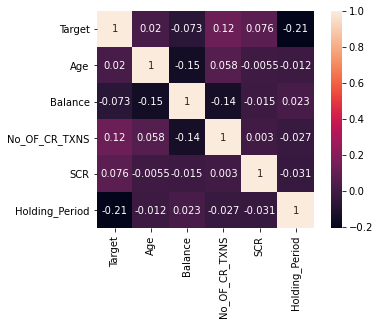

In [10]:
sns.heatmap(data.corr(), annot=True, square=True) # No strong correlations seen overall
plt.show()

###### Inferences: 

- `TARGET` does show maximum correlation w.r.t `No_OF_CR_TXNS` among other variables. Remaining correlations have to be visualized in order to understand if there's any sort of trend in data.

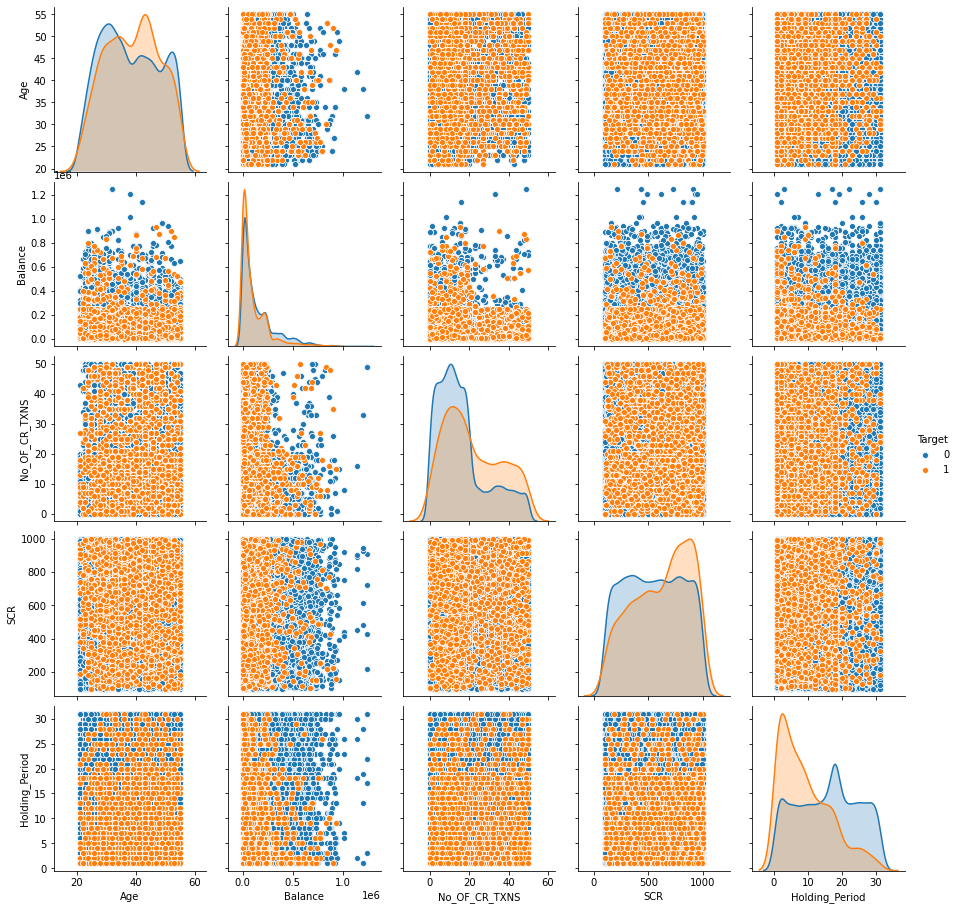

In [11]:
sns.pairplot(data, hue='Target')
plt.show()

##### Inferences from Pair-Plot: 

- People who tend to opt for loan have less `BALANCE` w.r.t people not buying loan.
- People having higher `BALANCE` tend to be in between 35-50 years of `AGE`.
- People having less `BALANCE` tend to show more interest towards loans i.e. higher `SCR` values.
- People having less `BALANCE` tend to have higher `No of Credit transactions` opt for loans.
- People having less `BALANCE` have higher `HOLDING PERIOD` who opt for loans.

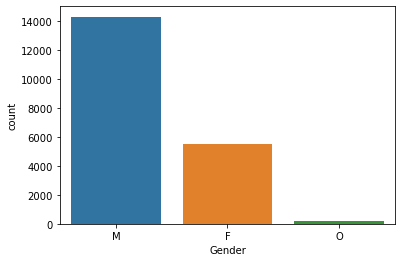

In [12]:
sns.countplot(x = data.Gender)
plt.show()

###### Inferences: 

- Since `GENDER` = `"OTHERS"/"O"` has very less population size i.e. less than 1% of entire data hence can be omitted as an attribute from `GENDER` category.

In [13]:
data.Gender.unique()

array(['M', 'F', 'O'], dtype=object)

In [14]:
data.Occupation.unique()

array(['SELF-EMP', 'SAL', 'SENP', 'PROF'], dtype=object)

In [15]:
data.Gender.value_counts()

M    14279
F     5525
O      196
Name: Gender, dtype: int64

In [16]:
data.drop(data.Gender[data.Gender== 'O'].index, axis = 0, inplace= True) # Removed 196 rows with `Gender` = 'O'

In [17]:
data.shape

(19804, 8)

In [18]:
data.Balance.describe()

count    1.980400e+04
mean     1.465609e+05
std      1.694485e+05
min      0.000000e+00
25%      2.399900e+04
50%      8.035100e+04
75%      2.183090e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [19]:
# sns.histplot(data.Age)

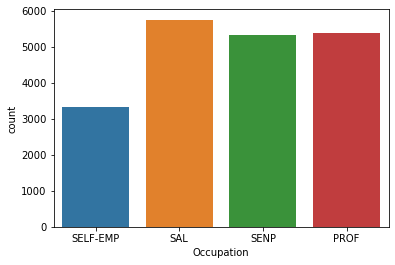

In [20]:
sns.countplot(x = data.Occupation)

###### Inferences: 

- The data consists mostly of `Salaried` category employees, whereas `Business Owners` and `Professionals` occupy the same strength in the data.

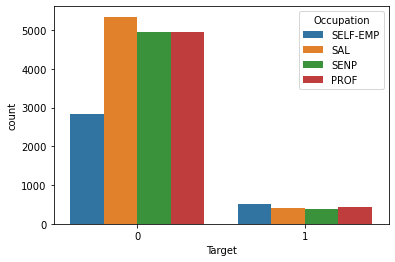

In [21]:
sns.countplot(x=data.Target, hue=data.Occupation) ## Self employed are much more likely to take loans

##### Inferences: 

- Most people who opted for loans tend to be either `Self-Employed` or `Small businesses` whereas `Salaried` people showed quite less interest in taking up loans since they had fixed income.

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


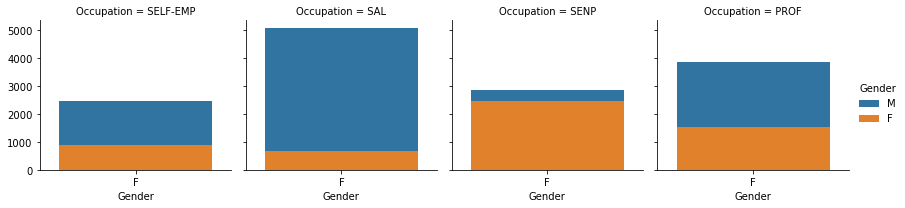

In [22]:
g = sns.FacetGrid(data, col='Occupation', hue="Gender")
plt.grid(True)
g.map(sns.countplot, "Gender", alpha=1)
g.add_legend()
plt.grid((False))

###### Inferences: 

- Most of the `Males` tend to be either in `Salaried` employee class (nearly 85%) or `working professionals` (nearly 70%) whereas most `Women` (nearly 90%) tend to start-up their own `business's` and manage them.

--------------------------

In [23]:
# sns.histplot(data.No_OF_CR_TXNS)

In [24]:
data.No_OF_CR_TXNS.describe()

count    19804.000000
mean        16.563169
std         12.928214
min          0.000000
25%          7.000000
50%         13.000000
75%         21.000000
max         50.000000
Name: No_OF_CR_TXNS, dtype: float64

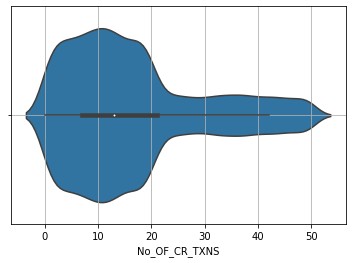

In [25]:
sns.violinplot(x=data.No_OF_CR_TXNS)
plt.grid(True)

###### Inferences: 

- The average `No. of Credit Transactions` tend to be in between 10 and 20. Whereas very few transactions tend to be in the number of 30-50.  

In [26]:
# len(data[data.No_OF_CR_TXNS==0].index)

In [27]:
# data.drop(index=data[data.No_OF_CR_TXNS==0].index, axis=0)

------------------

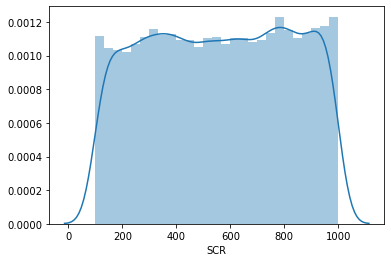

In [28]:
# sns.displot(data.SCR, kind = 'kde')
sns.distplot(data.SCR)
plt.show()

###### Inferences: 

- A uniform distribution can be observed for `SCR` and no skewness is found in the given data. 

In [29]:
data.SCR.describe()

count    19804.000000
mean       557.115987
std        260.562729
min        100.000000
25%        332.000000
50%        560.500000
75%        784.250000
max        999.000000
Name: SCR, dtype: float64

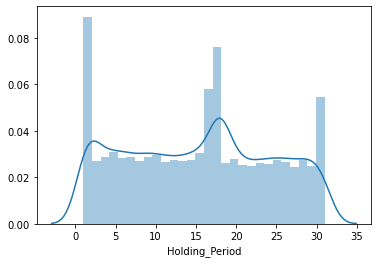

In [30]:
sns.distplot(data.Holding_Period)

In [31]:
data3 = data

### ------------------------------------------------------End of Exploratory Data Analysis-------------------------------------------------------
-----------
----------

### Pretty Report Printing Function

In [32]:
# A class for pretty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# function for validation on test data   
def classification_report(y_true, y_prediction, type_of_data='Enter Over/Under/Original sampled', type_of_classifier='ClassifierName'):
    """Print Classification report"""
    
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    
    print('Classification Report on Testing Data:\n'+ color.BOLD + type_of_data, 'data\n'+color.END+color.RED+color.BOLD+type_of_classifier,'Classifier'+color.END+color.END)
    print()
    print('---------------------------------------')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1 score: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print('---------------------------------------')
    print()


# A function for cross-validation report    
def cross_val_report(classifier, train_data, train_label, cv=10, scoring=['recall','precision', 'f1','accuracy']):
    
    score = cross_validate(classifier, train_data, train_label, cv=cv, scoring= scoring)
    recall = np.mean(score['test_recall'])
    precision = np.mean(score['test_precision'])
    f1 = np.mean(score['test_f1'])
    accuracy= np.mean(score['test_accuracy'])
    print('Cross Validation Report')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print()
    print("*Mean values presented")
    print('---------------------------------------')

### Creating the first set of training and test data on imbalanced data

In [33]:
df = pd.get_dummies(data, columns=['Gender','Occupation'], drop_first = True)
df.head()

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_M  \
0       0   41    91519             38  926              15         1   
1       0   52   117288             17  768              13         1   
2       0   31   259827              8  816               5         0   
3       0   45    26677             14  353              18         0   
4       0   39    43440              1  751              31         0   

   Occupation_SAL  Occupation_SELF-EMP  Occupation_SENP  
0               0                    1                0  
1               1                    0                0  
2               0                    0                1  
3               0                    0                0  
4               0                    0                1

#### Creating a model with Original Unbalanced data and measuring metrics

In [34]:
X_original = df.iloc[:,1:]
y_original = df.iloc[:,0]

In [35]:
X_original

Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_M  \
0       41    91519             38  926              15         1   
1       52   117288             17  768              13         1   
2       31   259827              8  816               5         0   
3       45    26677             14  353              18         0   
4       39    43440              1  751              31         0   
...    ...      ...            ...  ...             ...       ...   
19995   23    67612             20  164              27         0   
19996   34   472365              8  124               1         0   
19997   42   100642              4  263               1         1   
19998   36    29950             10  345              31         1   
19999   33    48964              4  800              13         1   

       Occupation_SAL  Occupation_SELF-EMP  Occupation_SENP  
0                   0                    1                0  
1                   1                    0                0  
2                   0                    0                1  
3                   0                    0                0  
4                   0                    0                1  
...               ...                  ...              ...  
19995               0                    0                1  
19996               0                    0                0  
19997               1                    0                0  
19998               0                    0                1  
19999               0                    0                0  

[19804 rows x 9 columns]

In [36]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,y_original, shuffle = ['True'], stratify=y_original)

### ------------------------------------------------------Start of Model Exploration---------------------------------------------------------------

## DecisionTreeClassifier - Original Data

Classification Report on Testing Data:
Original data
Decision Tree Classifier

---------------------------------------
Recall: 0.10070257611241218
Precision: 0.589041095890411
F1 score: 0.172
Accuracy: 0.916380529186023
---------------------------------------



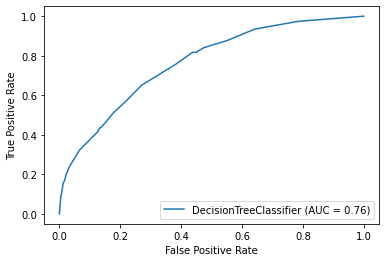

In [37]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train_orig, y_train_orig)
y_prediction_orig = clf.predict(X_test_orig)
classification_report(y_test_orig, y_prediction_orig, 'Original', 'Decision Tree')
plot_roc_curve(clf, X_test_orig, y_test_orig)
plt.show()
# cross_val_report(clf, y_test_orig,y_under_prediction.reshape(1,-1))

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y_test_orig, y_prediction_orig)

array([[4494,   30],
       [ 384,   43]], dtype=int64)

### High confidence and correct, but low prediction count

-----------

#### Create undersampled data and fit a model

In [40]:
X_under_train, y_under_train = NearMiss().fit_resample(X_train_orig, y_train_orig)

In [41]:
data[data.Target==1].shape

(1709, 8)

In [42]:
X_under_train.shape, y_under_train.shape

((2564, 9), (2564,))

## DecisionTreeClassifier - UnderSampled Data

Classification Report on Testing Data:
Undersampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.7142857142857143
Precision: 0.08650028360748724
F1 score: 0.1543131798633949
Accuracy: 0.324782872147041
---------------------------------------



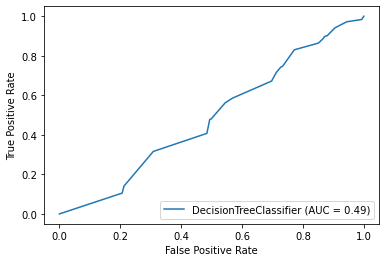

In [43]:
clf_under_sampled = DecisionTreeClassifier(max_depth = 5)
clf_under_sampled.fit(X_under_train, y_under_train)
y_under_prediction = clf_under_sampled.predict(X_test_orig)
classification_report(y_test_orig,y_under_prediction, 'Undersampled', 'Decision Tree')
plot_roc_curve(clf_under_sampled, X_test_orig, y_test_orig)

In [44]:
confusion_matrix(y_test_orig, y_under_prediction)

array([[1303, 3221],
       [ 122,  305]], dtype=int64)

Makes much more predictions, but s = .097

Similar as above

In [45]:
# cross_val_report(clf_under_sampled, y_test_orig,y_under_prediction)

## crossval here causes unbalanced split

In [46]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_under_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

--------------------

> Model on  an oversampled dataset

In [47]:
X_over_train, y_over_train = SMOTE().fit_resample(X_train_orig, y_train_orig)

## DecisionTreeClassifier - OverSampled Data

Classification Report on Testing Data:
Oversampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.4262295081967213
Precision: 0.1743295019157088
F1 score: 0.24745071380013597
Accuracy: 0.7764088063017572
---------------------------------------



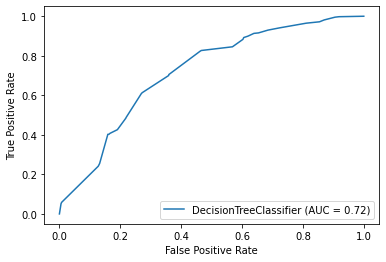

In [48]:
clf_over_sampled = DecisionTreeClassifier(max_depth = 5)
clf_over_sampled.fit(X_over_train, y_over_train)
y_over_predict = clf_over_sampled.predict(X_test_orig)
classification_report(y_test_orig, y_over_predict, 'Oversampled', 'Decision Tree')
plot_roc_curve(clf_over_sampled, X_test_orig, y_test_orig)

In [49]:
confusion_matrix(y_test_orig, y_over_predict)

array([[3662,  862],
       [ 245,  182]], dtype=int64)

In [50]:
s = 0.22805017103762829 ## higher predictions and better confidence

In [51]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_over_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

---------------

In [52]:
print("Original:     "+color.BOLD+ "X_original,y_original"+color.END+"::  X_train_orig, X_test_orig, y_train_orig, y_test_orig")
print()
print("Undersampled:"+color.BOLD+ " X_under, y_under"+color.END+"     ::  X_under_train, y_under_train")
print()
print("Oversampled:"+color.BOLD+ "  X_over, y_over"+color.END+"       ::  X_over_train, y_over_train")

Original:     X_original,y_original::  X_train_orig, X_test_orig, y_train_orig, y_test_orig

Undersampled: X_under, y_under     ::  X_under_train, y_under_train

Oversampled:  X_over, y_over       ::  X_over_train, y_over_train


The above datasets can be better sampled by adjusting hyper-parameters of NearMiss and SMOTE, or other methods of sampling could be used

-----------
-----------

## SVM Classifiers applied

*SVC fails to fit on original dataset, possibly because of unbalance*

In [53]:
# clf_svc0 = SVC()
# clf_svc0.fit(X_under_train, y_under_train)
# y_predict = clf_svc0.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Undersampled', 'SVM')
# plot_roc_curve(clf_svc0, X_test_orig, y_test_orig)
# cross_val_report(clf_svc0, X_under_train, y_under_train)

In [54]:
# confusion_matrix(y_test_orig, y_over_predict)

In [55]:
# %%time
# # Will take LONG Time for Training
# clf_svc1 = SVC()
# clf_svc1.fit(X_over_train, y_over_train)
# y_predict = clf_svc1.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Oversampled', 'SVM')
# plot_roc_curve(clf_svc1, X_test_orig, y_test_orig)
# cross_val_report(clf_svc1, X_under_train, y_under_train)

-------------
--------------------

## KNN Classifier - Original Data

Classification Report on Testing Data:
Original data
KNN Classifier

---------------------------------------
Recall: 0.07728337236533958
Precision: 0.38372093023255816
F1 score: 0.12865497076023394
Accuracy: 0.9097152090486771
---------------------------------------

Cross Validation Report
Recall: 0.6255995639534884
Precision: 0.7260765597853449
F1: 0.6704341798394484
Accuracy: 0.6919078307392995

*Mean values presented
---------------------------------------


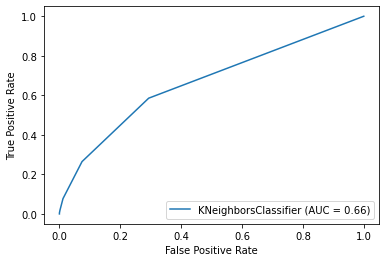

In [56]:
clf_KNN0 = KNeighborsClassifier()
clf_KNN0.fit(X_train_orig, y_train_orig)
y_predict= clf_KNN0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'KNN')
plot_roc_curve(clf_KNN0, X_test_orig, y_test_orig)
cross_val_report(clf_KNN0, X_under_train, y_under_train)

In [57]:
confusion_matrix(y_test_orig, y_predict)

array([[4471,   53],
       [ 394,   33]], dtype=int64)

In [58]:
349/3050

0.11442622950819673

-----------

## KNN Classifier - Undersampled Data

Classification Report on Testing Data:
Undersampled data
KNN Classifier

---------------------------------------
Recall: 0.6885245901639344
Precision: 0.0759493670886076
F1 score: 0.13680781758957655
Accuracy: 0.2506564330438295
---------------------------------------

Cross Validation Report
Recall: 0.6255995639534884
Precision: 0.7260765597853449
F1: 0.6704341798394484
Accuracy: 0.6919078307392995

*Mean values presented
---------------------------------------


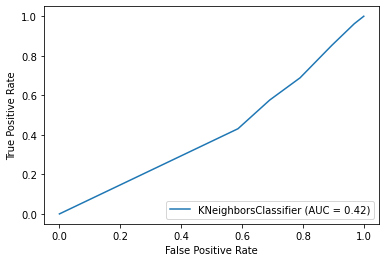

In [59]:
clf_KNN1 = KNeighborsClassifier()
clf_KNN1.fit(X_under_train, y_under_train)
y_predict= clf_KNN1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'KNN')
plot_roc_curve(clf_KNN1, X_test_orig, y_test_orig)
cross_val_report(clf_KNN1, X_under_train, y_under_train)

In [60]:
confusion_matrix(y_test_orig, y_predict)

array([[ 947, 3577],
       [ 133,  294]], dtype=int64)

In [61]:
311/3596

0.08648498331479422

----------
----------

## Random Forest Classifier - Original Data

Classification Report on Testing Data:
Original data
Random Forest Classifier

---------------------------------------
Recall: 0.14754098360655737
Precision: 0.7411764705882353
F1 score: 0.24609375
Accuracy: 0.9220359523328621
---------------------------------------

Cross Validation Report
Recall: 0.7878452034883721
Precision: 0.7990210687701735
F1: 0.7921303529836327
Accuracy: 0.7932605787937743

*Mean values presented
---------------------------------------


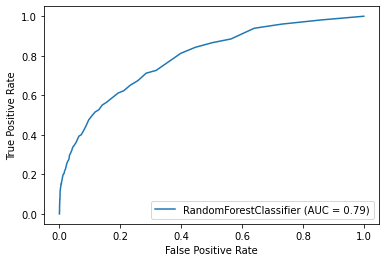

In [62]:
clf_rf0 = RandomForestClassifier()
clf_rf0.fit(X_train_orig, y_train_orig)
y_predict= clf_rf0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Random Forest')
plot_roc_curve(clf_rf0, X_test_orig, y_test_orig)
cross_val_report(clf_rf0, X_under_train, y_under_train)

In [63]:
confusion_matrix(y_test_orig, y_predict)

array([[4502,   22],
       [ 364,   63]], dtype=int64)

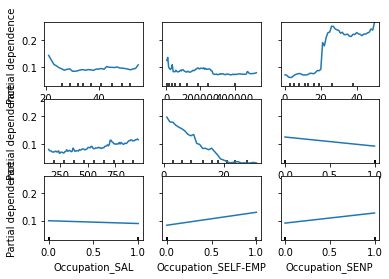

In [64]:
plot_partial_dependence(clf_rf0, X_test_orig, X_test_orig.columns)

-------------

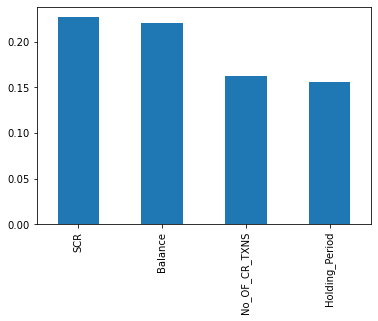

In [65]:
(pd.Series(clf_rf0.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='bar'))

##### Inferences: 

- The prominent features are: `SCR`,`BALANCE`,`No_OF_CR_TXNS`,`Holding_Period`

## RFE Implementation

In [66]:
from sklearn.feature_selection import RFE

In [67]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=4)
rfe = rfe.fit(X_over_train, y_over_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True False False False False]
[2 1 1 1 1 5 3 6 4]


In [68]:
X_over_train.columns

Index(['Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period', 'Gender_M',
       'Occupation_SAL', 'Occupation_SELF-EMP', 'Occupation_SENP'],
      dtype='object')

##### Inferences:

- RFE algorithm decided prominent features: `SCR`,`BALANCE`,`No_OF_CR_TXNS`,`Holding_Period`

In [69]:
categorical_features_indices = np.where(X_train_orig.dtypes != np.float)[0]

In [70]:
categorical_features_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

## RandomForest Classifier - Undersampled Data

In [71]:
X_train_orig.columns

Index(['Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period', 'Gender_M',
       'Occupation_SAL', 'Occupation_SELF-EMP', 'Occupation_SENP'],
      dtype='object')

Classification Report on Testing Data:
Undersampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8290398126463701
Precision: 0.09977452085682074
F1 score: 0.1781132075471698
Accuracy: 0.3401333064027469
---------------------------------------

Cross Validation Report
Recall: 0.7894016472868217
Precision: 0.7996497919912923
F1: 0.7935647935767607
Accuracy: 0.7948306785019456

*Mean values presented
---------------------------------------


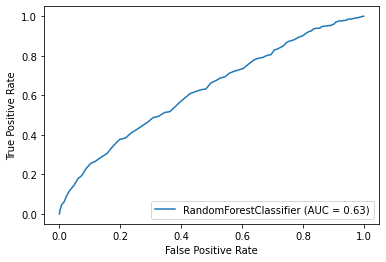

In [72]:
clf_rf1 = RandomForestClassifier()
clf_rf1.fit(X_under_train, y_under_train)
y_predict= clf_rf1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Random Forest')
plot_roc_curve(clf_rf1, X_test_orig, y_test_orig)
cross_val_report(clf_rf1, X_under_train, y_under_train)

In [73]:
confusion_matrix(y_test_orig, y_predict)

array([[1330, 3194],
       [  73,  354]], dtype=int64)

-------------

## RandomForest Classifier - Oversampled Data

In [74]:
clf_rf2 = RandomForestClassifier()

Classification Report on Testing Data:
Oversampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8220140515222483
Precision: 0.09923664122137404
F1 score: 0.1770938446014127
Accuracy: 0.3411432033932539
---------------------------------------

Cross Validation Report
Recall: 0.7932897286821705
Precision: 0.806704479773693
F1: 0.7992148094989803
Accuracy: 0.8006718142023346

*Mean values presented
---------------------------------------


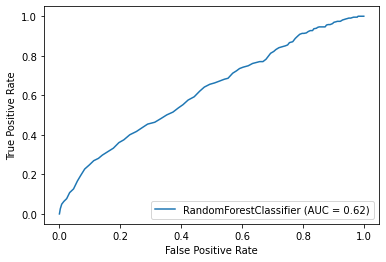

In [75]:
clf_rf2.fit(X_under_train, y_under_train)
y_predict= clf_rf2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Random Forest')
plot_roc_curve(clf_rf2, X_test_orig, y_test_orig)
cross_val_report(clf_rf2, X_under_train, y_under_train)

In [76]:
confusion_matrix(y_test_orig, y_predict)

array([[1338, 3186],
       [  76,  351]], dtype=int64)

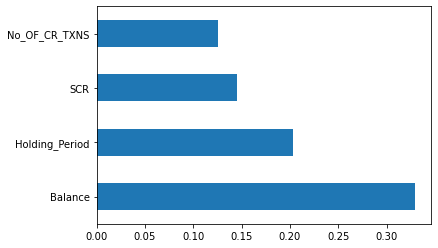

In [77]:
(pd.Series(clf_rf2.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='barh'))

----------
----------------

## Logistic Regression - Original Data

In [78]:
from sklearn.linear_model import LogisticRegression

C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report on Testing Data:
Original data
Logistic Regression Classifier

---------------------------------------
Recall: 0.0
Precision: 0.0
F1 score: 0.0
Accuracy: 0.9137547970107049
---------------------------------------

Cross Validation Report
Recall: 0.6902737403100775
Precision: 0.6709292493945085
F1: 0.6792860925450427
Accuracy: 0.6728280034046692

*Mean values presented
---------------------------------------


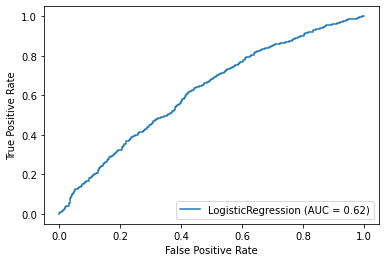

In [79]:
lr0 = LogisticRegression(max_iter=1000)
lr0.fit(X_train_orig, y_train_orig)
y_predict= lr0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Logistic Regression')
plot_roc_curve(lr0, X_test_orig, y_test_orig)
cross_val_report(lr0, X_under_train, y_under_train)

In [80]:
confusion_matrix(y_test_orig, y_predict)

array([[4524,    0],
       [ 427,    0]], dtype=int64)

## Logistic Regression - Undersampled Data

Classification Report on Testing Data:
Undersampled data
Logistic Regression Classifier

---------------------------------------
Recall: 0.667447306791569
Precision: 0.1370851370851371
F1 score: 0.2274541101356744
Accuracy: 0.6089678852757019
---------------------------------------

Cross Validation Report
Recall: 0.6902737403100775
Precision: 0.6709292493945085
F1: 0.6792860925450427
Accuracy: 0.6728280034046692

*Mean values presented
---------------------------------------


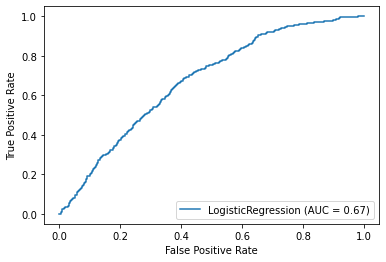

In [81]:
lr1 = LogisticRegression(max_iter=100)
lr1.fit(X_under_train, y_under_train)
y_predict= lr1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

In [82]:
confusion_matrix(y_test_orig, y_predict)

array([[2730, 1794],
       [ 142,  285]], dtype=int64)

## Logistic Regression - Oversampled Data

Classification Report on Testing Data:
Oversampled data
Logistic Regression Classifier

---------------------------------------
Recall: 0.6627634660421545
Precision: 0.17110036275695284
F1 score: 0.2719846227775108
Accuracy: 0.6940012118763886
---------------------------------------

Cross Validation Report
Recall: 0.6902737403100775
Precision: 0.6709292493945085
F1: 0.6792860925450427
Accuracy: 0.6728280034046692

*Mean values presented
---------------------------------------


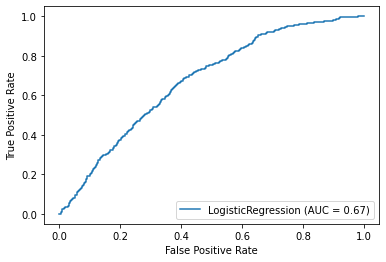

In [83]:
lr2 = LogisticRegression(max_iter=100)
lr2.fit(X_over_train, y_over_train)
y_predict= lr2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

In [84]:
confusion_matrix(y_test_orig, y_predict)

array([[3153, 1371],
       [ 144,  283]], dtype=int64)

------
------

## KNN Classifier - Oversampled Data

Classification Report on Testing Data:
Oversampled data
KNN Classifier

---------------------------------------
Recall: 0.5362997658079626
Precision: 0.1579310344827586
F1 score: 0.24400639318060738
Accuracy: 0.7133912340941224
---------------------------------------

Cross Validation Report
Recall: 0.6255995639534884
Precision: 0.7260765597853449
F1: 0.6704341798394484
Accuracy: 0.6919078307392995

*Mean values presented
---------------------------------------


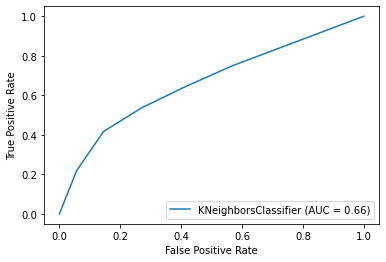

In [85]:
clf_KNN2 = KNeighborsClassifier()
clf_KNN2.fit(X_over_train, y_over_train)
y_predict= clf_KNN2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'KNN')
plot_roc_curve(clf_KNN2, X_test_orig, y_test_orig)
cross_val_report(clf_KNN2, X_under_train, y_under_train)

In [86]:
confusion_matrix(y_test_orig, y_predict)

array([[3303, 1221],
       [ 198,  229]], dtype=int64)

**_Segment the customer with prob >90, 80>prob>90, 70>prob>80, 60>prob>70 and so on_**

In [87]:
predict_prob = clf_KNN2.predict_proba(X_test_orig)
predict_prob.shape
# print more significant digits here

(4951, 2)

In [88]:
# predict_prob

In [89]:
predictions = pd.DataFrame(predict_prob, columns=[0, 'PredictionProb'])

In [90]:
# predictions.head()

In [91]:
predictions_prob = predictions.drop(0, axis=1)

In [92]:
y = pd.DataFrame(y_test_orig, columns = ['Target'])
y = y.reset_index(drop=True)

In [93]:
error = y.Target- predictions_prob.PredictionProb

In [94]:
# This series indicate the error, closer to zero values mean better prediction
# positive mean that my model should have predicted loan taker, but did not
# negative means that model should have predicted NOT a loan taker, but did predict as such

## Target - Probablity - KNN

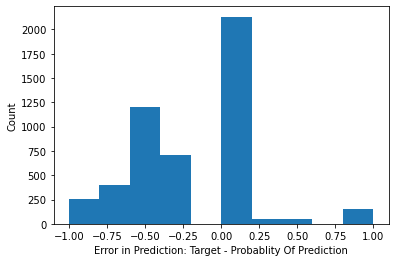

In [95]:
plt.hist(error)
plt.xlabel('Error in Prediction: Target - Probablity Of Prediction')
plt.ylabel("Count")
plt.show()

### ------------------------------------------------------End of Model Exploration---------------------------------------------------------------

## PRE-BUCKETING VISUALIZATIONS FOR INFERENCES

### SCR Vs Occupation Vs Target

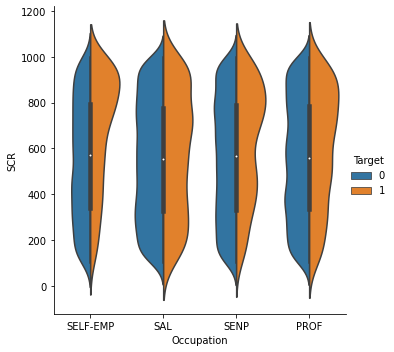

In [96]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

##### Inferences: 

- `SELF-EMP` class tends to have more `SCR` values who are likely to opt for loans.
- `SAL` class shows uniformity across `SCR` for people opting/not opting for loans.
- `SENP` business class tend to show similar fashion like `SELF-EMP` class when it comes to opting for loans.
- `PROF` class tends to lie somewhere between `SENP` and `SAL` class.

### SCR Vs Occupation Vs Target

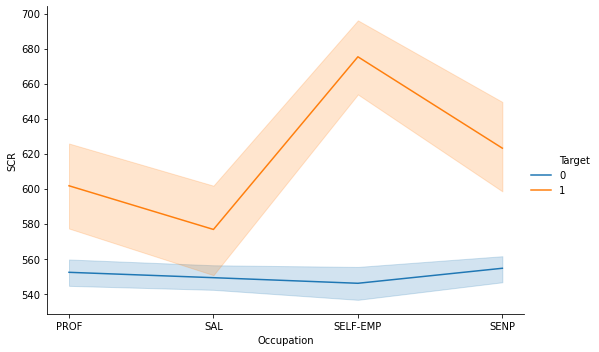

In [97]:
sns.relplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=1.5, kind = "line")
plt.show()

### SCR Vs Occupation Vs Target

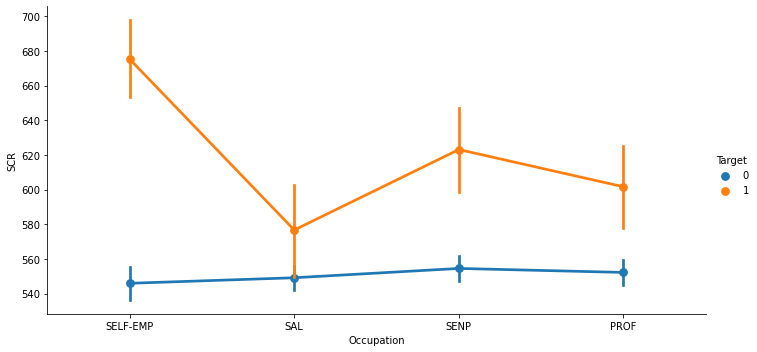

In [98]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=2.0, kind = "point")
plt.show()

##### Inferences: 

- `SELF-EMP`class, there can be seen a high `SCR` value ranging between 660 to 700 points who have shown interest in opting for loans whereas least interest in the same class was shown at 540 to 550 points of `SCR`

- `SENP` class. are the second in line to opt for Loans, as they tend to show comaratively hgiher `SCR` values in the line graph above.

In [99]:
data1 = data.copy()

## Bucketing for AGE values

#### pd.qcut() function

In [100]:
data1['Ageb'] = pd.qcut(data['Age'], q=4)

In [101]:
data1.head()

Target  Age Gender  Balance Occupation  No_OF_CR_TXNS  SCR  Holding_Period  \
0       0   41      M    91519   SELF-EMP             38  926              15   
1       0   52      M   117288        SAL             17  768              13   
2       0   31      F   259827       SENP              8  816               5   
3       0   45      F    26677       PROF             14  353              18   
4       0   39      F    43440       SENP              1  751              31   

           Ageb  
0  (38.0, 46.0]  
1  (46.0, 55.0]  
2  (30.0, 38.0]  
3  (38.0, 46.0]  
4  (38.0, 46.0]

#### AGE Intervals

In [102]:
data1.Ageb.value_counts()

(30.0, 38.0]      5188
(20.999, 30.0]    5136
(46.0, 55.0]      4936
(38.0, 46.0]      4544
Name: Ageb, dtype: int64

In [103]:
data1.dtypes

Target               int64
Age                  int64
Gender              object
Balance              int32
Occupation          object
No_OF_CR_TXNS        int64
SCR                  int64
Holding_Period       int64
Ageb              category
dtype: object

In [104]:
data1.Ageb

0          (38.0, 46.0]
1          (46.0, 55.0]
2          (30.0, 38.0]
3          (38.0, 46.0]
4          (38.0, 46.0]
              ...      
19995    (20.999, 30.0]
19996      (30.0, 38.0]
19997      (38.0, 46.0]
19998      (30.0, 38.0]
19999      (30.0, 38.0]
Name: Ageb, Length: 19804, dtype: category
Categories (4, interval[float64]): [(20.999, 30.0] < (30.0, 38.0] < (38.0, 46.0] < (46.0, 55.0]]

In [105]:
data1.head(5)

Target  Age Gender  Balance Occupation  No_OF_CR_TXNS  SCR  Holding_Period  \
0       0   41      M    91519   SELF-EMP             38  926              15   
1       0   52      M   117288        SAL             17  768              13   
2       0   31      F   259827       SENP              8  816               5   
3       0   45      F    26677       PROF             14  353              18   
4       0   39      F    43440       SENP              1  751              31   

           Ageb  
0  (38.0, 46.0]  
1  (46.0, 55.0]  
2  (30.0, 38.0]  
3  (38.0, 46.0]  
4  (38.0, 46.0]

In [106]:
# sns.pairplot(data1, hue='Target')

In [107]:
data1 = pd.get_dummies(data1)

In [108]:
data1.head(2)

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_F  \
0       0   41    91519             38  926              15         0   
1       0   52   117288             17  768              13         0   

   Gender_M  Occupation_PROF  Occupation_SAL  Occupation_SELF-EMP  \
0         1                0               0                    1   
1         1                0               1                    0   

   Occupation_SENP  Ageb_(20.999, 30.0]  Ageb_(30.0, 38.0]  Ageb_(38.0, 46.0]  \
0                0                    0                  0                  1   
1                0                    0                  0                  0   

   Ageb_(46.0, 55.0]  
0                  0  
1                  1

In [109]:
data2 = data1.copy()

In [110]:
data1.columns

Index(['Target', 'Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period',
       'Gender_F', 'Gender_M', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'Ageb_(20.999, 30.0]',
       'Ageb_(30.0, 38.0]', 'Ageb_(38.0, 46.0]', 'Ageb_(46.0, 55.0]'],
      dtype='object')

### Age Bucket Ranking Function

In [111]:
cols = ['Ageb_(30.0, 38.0]', 'Ageb_(20.999, 30.0]','Ageb_(46.0, 55.0]','Ageb_(38.0, 46.0]']

def func1(x):
    if x ==1:
        return 1
def func2(x):
    if x ==1:
        return 2

def func3(x):
    if x ==1:
        return 3

def func4(x):
    if x ==1:
        return 4


data1['age_d'] = data1['Ageb_(30.0, 38.0]'].apply(func1)
data1['age_d'] = data1['Ageb_(20.999, 30.0]'].apply(func2)
data1['age_d'] = data1['Ageb_(46.0, 55.0]'].apply(func3)
data1['age_d'] = data1['Ageb_(38.0, 46.0]'].apply(func4)

In [112]:
for ind, row in data1.iterrows():
    if row['Ageb_(20.999, 30.0]'] ==1:
        data1.loc[ind, 'age_d'] = 1
    elif row['Ageb_(30.0, 38.0]'] ==1:
        data1.loc[ind, 'age_d'] = 2
    elif row['Ageb_(38.0, 46.0]'] ==1:
        data1.loc[ind, 'age_d'] = 3
    elif row['Ageb_(46.0, 55.0]'] ==1:
        data1.loc[ind, 'age_d'] = 4

In [113]:
data1.age_d.value_counts()

2.0    5188
1.0    5136
4.0    4936
3.0    4544
Name: age_d, dtype: int64

#### Converting Age buckets to integer type

In [114]:
data1.age_d = data1.age_d.astype('int32')

In [115]:
data1.head()

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_F  \
0       0   41    91519             38  926              15         0   
1       0   52   117288             17  768              13         0   
2       0   31   259827              8  816               5         1   
3       0   45    26677             14  353              18         1   
4       0   39    43440              1  751              31         1   

   Gender_M  Occupation_PROF  Occupation_SAL  Occupation_SELF-EMP  \
0         1                0               0                    1   
1         1                0               1                    0   
2         0                0               0                    0   
3         0                1               0                    0   
4         0                0               0                    0   

   Occupation_SENP  Ageb_(20.999, 30.0]  Ageb_(30.0, 38.0]  Ageb_(38.0, 46.0]  \
0                0                    0                  0                  1   
1                0                    0                  0                  0   
2                1                    0                  1                  0   
3                0                    0                  0                  1   
4                1                    0                  0                  1   

   Ageb_(46.0, 55.0]  age_d  
0                  0      3  
1                  1      4  
2                  0      2  
3                  0      3  
4                  0      3

## POST-BUCKETING VISUALIZATIONS FOR INFERENCES

### SCR Vs Age-Category Vs Target

AGE Intervals & Ranking

- (20.9, 30.0]   ----> 1
- (30.0, 38.0]   ----> 2
- (38.0, 46.0]   ----> 3
- (46.0, 55.0]   ----> 4

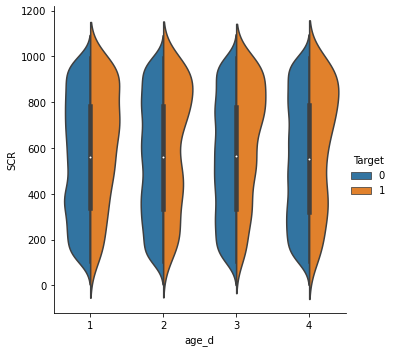

In [116]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

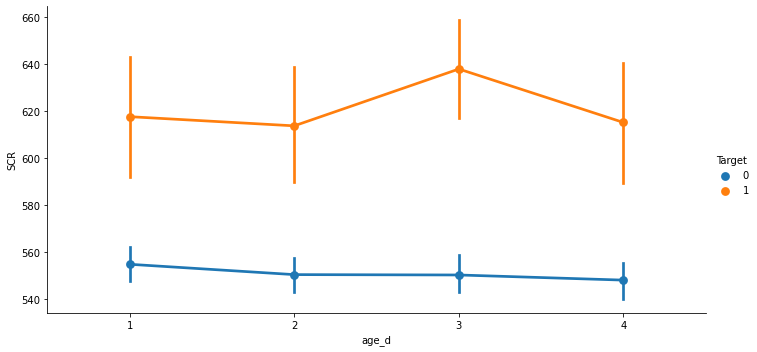

In [117]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, aspect=2.0, kind = "point")
plt.show()

##### Inferences: 

- The `Age groups` `(20.9-30] years` and `(38-46] years` tend to showwcase higher `SCR` values hence more interest towards opting for lonans. However, the age groups (30-38] and (46.0-55) showcase least interest in opting for loans.

### SCR Vs Age-Category Vs Target

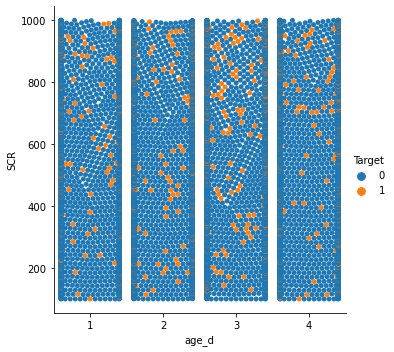

In [118]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "swarm")
plt.show()

In [119]:
sns.set_style('ticks')

## BUCKETING SCR & HOLDING PERIODS

In [120]:
data1['SCRb'] = pd.qcut(data['SCR'], q=5)

In [121]:
data1.SCRb.value_counts()

(99.999, 288.0]    3987
(468.0, 651.0]     3964
(826.0, 999.0]     3956
(651.0, 826.0]     3952
(288.0, 468.0]     3945
Name: SCRb, dtype: int64

In [122]:
data1['HPB'] = pd.qcut(data['Holding_Period'], q=4)

In [123]:
data1.HPB.value_counts()

(0.999, 8.0]    5519
(16.0, 23.0]    4998
(8.0, 16.0]     4791
(23.0, 31.0]    4496
Name: HPB, dtype: int64

In [124]:
data1.head()

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_F  \
0       0   41    91519             38  926              15         0   
1       0   52   117288             17  768              13         0   
2       0   31   259827              8  816               5         1   
3       0   45    26677             14  353              18         1   
4       0   39    43440              1  751              31         1   

   Gender_M  Occupation_PROF  Occupation_SAL  Occupation_SELF-EMP  \
0         1                0               0                    1   
1         1                0               1                    0   
2         0                0               0                    0   
3         0                1               0                    0   
4         0                0               0                    0   

   Occupation_SENP  Ageb_(20.999, 30.0]  Ageb_(30.0, 38.0]  Ageb_(38.0, 46.0]  \
0                0                    0                  0                  1   
1                0                    0                  0                  0   
2                1                    0                  1                  0   
3                0                    0                  0                  1   
4                1                    0                  0                  1   

   Ageb_(46.0, 55.0]  age_d            SCRb           HPB  
0                  0      3  (826.0, 999.0]   (8.0, 16.0]  
1                  1      4  (651.0, 826.0]   (8.0, 16.0]  
2                  0      2  (651.0, 826.0]  (0.999, 8.0]  
3                  0      3  (288.0, 468.0]  (16.0, 23.0]  
4                  0      3  (651.0, 826.0]  (23.0, 31.0]

### SCR-Bucketed Vs Age-Category Vs Target

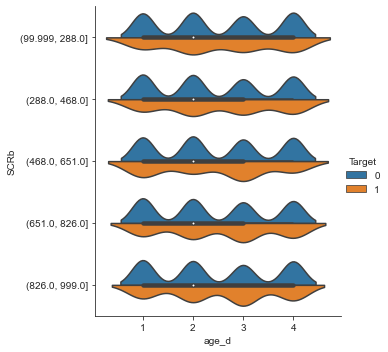

In [125]:
sns.catplot(x="age_d", y="SCRb", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

KeyboardInterrupt: 

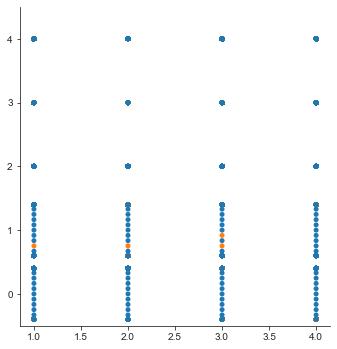

In [126]:
sns.catplot(x="age_d", y="SCRb", hue = "Target",data=data1, kind = "swarm")
plt.show()

##### Inferences: 

- People in the `Age Group` `(46.0, 55.0]` years tend to have higher `SCR` score i.e. 826 to 1000 points and opt for loans as compared to `(30.0, 38.0]` years who stand at the second position for higher `SCR` values i.e. 650 to 830 points.

- People in the `Age Group` `(38.0, 46.0]` years tend to have `SCR` values between 400 to 650 points.

### Holding Period Bucketed Vs Age-Category Vs Target

In [ ]:
sns.catplot(x="age_d", y="HPB", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

In [ ]:
sns.catplot(x="HPB", y="age_d", hue = "Target",data=data1, kind = "swarm")
plt.show()

##### Inferences: 

- Higher the `Holding Period` more stable is the money in the person's account. 
- `Holding Period` of 23-31 weeks tends to be uniform across all the `Age Groups`
- `Holding Period` between 1-8 weeks tends to lie in the `Age Groups` = 2 and 3 i.e. (30.0, 38.0] and (38.0, 46.0]

### Pair-Plot on Bucketed Data

In [ ]:
sns.pairplot(data1, hue = 'Target')
plt.show()

##### Inferences from Pair-Plot: 

- People who tend to opt for loan have less `BALANCE` w.r.t people not buying loan.
- People having higher `BALANCE` tend to be in between 35-50 years of `AGE`.
- People having less `BALANCE` tend to show more interest towards loans i.e. higher `SCR` values.
- People having less `BALANCE` tend to have higher `No of Credit transactions` opt for loans.
- People having less `BALANCE` have higher `HOLDING PERIOD` who opt for loans.

------

### ----------------------------------------------------Start of Black Box Models Exploration------------------------------------------------

## SHAP - BlackBox Model

In [ ]:
# import shap

In [ ]:
# X_train_summary = shap.kmeans(X_train_orig, 10)

In [ ]:
# explainerKNN = shap.KernelExplainer(clf_KNN0.predict,X_train_summary)

In [ ]:
# shap_values_KNN_test = explainerKNN.shap_values(X_test_orig)

In [ ]:
# shap.initjs()
# shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[:1000,:], X_test_orig.iloc[:1000,:])

## LIME- BlackBox Model

In [ ]:
# import lime
# import lime.lime_tabular

In [ ]:
# lgb_params = {
#   'task': 'train',
#     'boosting_type': 'goss',
#     'objective': 'binary',
#     'metric':'binary_logloss',
#     'metric': {'l2', 'auc'},
#     'num_leaves': 50,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'verbose': None,
#     'num_iteration':100,
#     'num_threads':7,
#     'max_depth':12,
#     'min_data_in_leaf':100,
#     'alpha':0.5}

In [ ]:
# import warnings
# from lime import submodular_pick
# import lightgbm as lgb

# lgb_train = lgb.Dataset(X_train_orig, y_train_orig)
# lgb_eval = lgb.Dataset(X_test_orig, y_test_orig)

# model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)
# lime.lime_tabular.LimeTabularExplainer(data[model.feature_name()].astype(int).values,  
# mode='classification',training_labels=data3['Target'],feature_names=model.feature_name())
# # Remember to convert the dataframe to matrix values
# # SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
# sp_obj = submodular_pick.SubmodularPick(explainer,data3[model.feature_name()].values, \
# prob, num_features=5,num_exps_desired=10)

# [exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

## CatBoost Classifier

In [ ]:
# from catboost import CatBoostClassifier
# model = CatBoostClassifier(random_seed=42)

In [ ]:
# cate_features_index = np.where(data.dtypes != float)[0]

In [ ]:
# X_over_train

In [ ]:
# model.fit(X_under_train,y_under_train,cat_features=cate_features_index)

In [ ]:
# test = pd.read_csv("test_data.csv")
# pred = model.predict(test)


In [ ]:
# from sklearn.metrics import confusion_matrix

In [ ]:
# confusion_matrix(y_test_orig, pred)

### ----------------------------------------------------End of Black Box Models Exploration------------------------------------------------

-----

## Model Evaluation Matrix - Which Models to be Considered?

In [127]:
model_eval = {'Good Fit Percent%': ['10.9','9.84','19.6','17.2','8.6','18.4','11.4','25.0','25.0','16.4','20.8','17.2'],
        'Comments': ['Not Considering','Not Considering','Not Considering','Not Considering','Not Considering','Not Considering',
                     'Not Considering','Considering','Considering','Not Considering','Considering','Not Considering',]
        }

df = pd.DataFrame(model_eval, columns = ['Good Fit Percent%','Comments'], index=['DecisionTreeClassifier - Original Data','DecisionTreeClassifier - UnderSampled Data','DecisionTreeClassifier - OverSampled Data',
                                                                           'KNN Classifier - Original Data','KNN Classifier - Undersampled Data','Random Forest Classifier - Original Data','RandomForest Classifier - Undersampled Data',
                                                                           'RandomForest Classifier - Oversampled Data','Logistic Regression - Original Data','Logistic Regression - Undersampled Data',
                                                                          'Logistic Regression - Oversampled Data','KNN Classifier - Oversampled Data'])

print (df)

                                            Good Fit Percent%         Comments
DecisionTreeClassifier - Original Data                   10.9  Not Considering
DecisionTreeClassifier - UnderSampled Data               9.84  Not Considering
DecisionTreeClassifier - OverSampled Data                19.6  Not Considering
KNN Classifier - Original Data                           17.2  Not Considering
KNN Classifier - Undersampled Data                        8.6  Not Considering
Random Forest Classifier - Original Data                 18.4  Not Considering
RandomForest Classifier - Undersampled Data              11.4  Not Considering
RandomForest Classifier - Oversampled Data               25.0      Considering
Logistic Regression - Original Data                      25.0      Considering
Logistic Regression - Undersampled Data                  16.4  Not Considering
Logistic Regression - Oversampled Data                   20.8      Considering
KNN Classifier - Oversampled Data                   

In [128]:
data1.to_excel("F:\\IBPA_IIM_FinalProject\\data1.xlsx")

In [154]:
df1 = data._get_numeric_data()

In [155]:
df1

Target  Age    Balance  No_OF_CR_TXNS  SCR  Holding_Period
0           0   41   91519.92             38  926              15
1           0   52  117288.96             17  768              13
2           0   31  259827.44              8  816               5
3           0   45   26677.55             14  353              18
4           0   39   43440.31              1  751              31
...       ...  ...        ...            ...  ...             ...
19995       0   23   67612.33             20  164              27
19996       0   34  472365.27              8  124               1
19997       0   42  100642.27              4  263               1
19998       0   36   29950.82             10  345              31
19999       0   33   48964.55              4  800              13

[20000 rows x 6 columns]

In [156]:
df1.head()

Target  Age    Balance  No_OF_CR_TXNS  SCR  Holding_Period
0       0   41   91519.92             38  926              15
1       0   52  117288.96             17  768              13
2       0   31  259827.44              8  816               5
3       0   45   26677.55             14  353              18
4       0   39   43440.31              1  751              31

In [157]:
vif = pd.DataFrame()

In [158]:
vif["VIF Factor"] = [variance_inflation_factor(X_original.values, i) for i in range(X_original.shape[1])]

In [159]:
vif["features"] = X_original.columns

In [160]:
vif.round(1)

VIF Factor             features
0         8.7                  Age
1         1.7              Balance
2         2.9        No_OF_CR_TXNS
3         4.8                  SCR
4         3.6       Holding_Period
5         3.9             Gender_M
6         2.1       Occupation_SAL
7         1.5  Occupation_SELF-EMP
8         1.9      Occupation_SENP

In [162]:
vif.round(3)

VIF Factor             features
0       8.749                  Age
1       1.699              Balance
2       2.866        No_OF_CR_TXNS
3       4.764                  SCR
4       3.553       Holding_Period
5       3.850             Gender_M
6       2.083       Occupation_SAL
7       1.542  Occupation_SELF-EMP
8       1.886      Occupation_SENP

### ------------------------------------------------------------End of Capstone---------------------------------------------------------------------
-----------